In [1]:
import habitat

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import coco

Using TensorFlow backend.


In [4]:
from mrcnn import utils
import os
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
from mrcnn import visualize
from PIL import Image
import mrcnn.model as modellib
from env import Env
from utils import draw_top_down_map, AgentPosition

In [5]:
mapper = [1, 40, 1, 16, 4, 2, 4, 39, 4, 1, 17, 0, 1, 1, 40, 4, 1, 1, 14, 4, 24, 1, 0, 1, -1, 39, 17, 4, 5, 1, 1, 39, 21, 1, 2, 1, 15, 39, 40, 1, 1, 4, 1, 7, 28, 39, 40, 28, 40, 40, 39, 40, 39, 39, 39, 39, 39, 2, 17, 1, 40, 1, 1, 5, 1, 34, 15, 1, 15, 1, 20, 1, 15, 1, 15, 20, 20, 39, 4, 39, 39, 39, 39, 39, 28, 28, 28, 40, 1, 12, 9, 1, 0, 4, 4, 40, 23, 17, 2, 1, 1, 4, 23, 39, 2, 17, 40, 40, 34, 1, 34, 1, 1, 9, 1, 28, 9, 4, 28, 39, 28, 40, 2, 28, 28, 38, 4, 4, 0, 11, 1, 17, 1, 1, 7, 0, 15, 40, 0, 21, 1, 7, 4, 0, 28, 4, 1, 4, 39, 2, 39, 39, 20, 39, 39, 39, 39, 39, 39, 23, 2, 1, 1, 1, 4, 23, 4, 17, 1, 24, 40, 1, 1, 24, 1, 4, 17, 14, 4, 4, 4, 1, 14, 28, 4, 4, 14, 35, 39, 28, 28, 28, 39, 2, 28, 16, 2, 39, 2, 1, 37, 7, 40, 31, 1, 17, 1, 4, 1, 26, 4, 1, 1, 4, 7, 4, 20, 1, 20, 22, 40, 40, 3, 40, 3, 3, 16, 5, 39, 5, 20, 39, 3, 3, 3, 3, 3, 20, 20, 17, 4, 1, 2, 1, 40, 38, 4, 1, 17, 1, 1, 40, 2, 17, 40, 1, 17, 9, 9, 1, 39, 16, 9, 9, 40, 40, 40, 4, 1, 17, 40, 26, 1, 2, 16, 1, 39]
index_to_title_map = {17: 'ceiling', 9: 'window', 8: 'cushion', 11: 'bed', 1: 'wall', 2: 'floor', 31: 'shelving', 4: 'door', 39: 'objects', 22: 'tv_monitor', 13: 'chest_of_drawers', 3: 'chair', 40: 'misc', 34: 'seating', 6: 'picture', 35: 'board_panel', 26: 'counter', 23: 'shower', 18: 'toilet', 21: 'mirror', 7: 'cabinet', 0: 'void', 28: 'lighting', 15: 'sink', 5: 'table', 12: 'curtain', 20: 'towel', 25: 'bathtub', 19: 'stool', 16: 'stairs', 38: 'clothes', -1: 'nope', 37: 'appliances', 27: 'fireplace', 29: 'beam', 10: 'sofa', 14: 'plant'}

In [6]:
num_classes = len(list(index_to_title_map.keys()))

In [7]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # Give the configuration a recognizable name
    NAME = "habitat"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = num_classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 640

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 64, 128, 256, 320)  # anchor side in pixels
    #RPN_ANCHOR_SCALES = (16, 64, 128, 256, 480)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
#     TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config_cnn = InferenceConfig()
config_cnn.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                49
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [8]:
index_to_title_map[-1] = 'nope'

model_classes = []
model_mapper = {}
to_model_mapper = {}

index = 0
for key in index_to_title_map:
    model_classes.append(index_to_title_map[key])
    model_mapper[index] = key
    to_model_mapper[key] = index
    index += 1

In [9]:
class HabitatDataset(utils.Dataset):
    
    def __init__(self, path, data=None):
        self.path = path
        
        scene = env.sim.semantic_annotations()
        index_to_title_map = {obj.category.index() + 1: obj.category.name() for obj in scene.objects }
        index_to_title_map[-1] = 'nope'
        
        self.class_names = model_classes
        self.source_class_ids = {'habitat': np.array(range(len(self.class_names)))}
        
        self.num_classes = len(self.class_names)
        
        if not(data is None):
            self.X = data['X']
            self.Y = data['Y']
            
            self._image_ids = range(len(self.X))
            
            self.image_info = []
            
            for index in range(len(self.X)):
                self.image_info.append({
                    'id': index,
                    'source': 'habitat',
                    'path': None,
                    'width': 320,
                    'height': 640,
                })
    
    def prepare_dataset(self):
        x_path = self.path + '/X'
        y_path = self.path + '/Y'
        
        print(x_path,'\t',y_path)
        
        x_images = {}
        for root, dirs, files in os.walk(x_path, topdown=False):
            for file in files:
                
                
                #print(root + "/" + file)
                img = image.imread(root + "/" + file)
            
                x_images[file[:-4]] = (img * 256).astype('int')
                
        y_images = {}
        y_classes = {}
        
        for root, dirs, files in os.walk(y_path, topdown=False):
            
            
            if len(dirs) > 0:
                continue
                
            title = root[root.rfind("/") + 1:]
            y_images[title] = []     
            y_classes[title] = []
            
            for file in files:
                img = image.imread(root + "/" + file)
                
                
                y_images[title].append(img)
                #print(file,'/t',title)
                class_name = int(file[:-4])#mapper[int(file[:-4])]
                y_classes[title].append(class_name)
                
        X = []
        Y = []
        Y_classes = []
        
        for key in x_images:
            if key not in y_images:
                print('error ' + key);
                continue
            
            X.append(x_images[key])
            
            class_count = len(y_images[key])
            y_images[key] = self.__reshape_mask(np.array(y_images[key]))
            
            Y.append((y_images[key], self.__convert_class_to_id(y_classes[key])))
        
        print('prepared ' + str(len(X)) + " images")
        
        self.X = np.array(X)
        self.Y = np.array(Y)
        
        self._image_ids = range(len(self.X))
        

    def load_image(self, image_id):
        return self.X[image_id]
        
    def load_mask(self, image_id):
        return self.Y[image_id]
    
    def __convert_class_to_id(self, classes):
        response = []
        
        for item in classes:
            if item not in list(index_to_title_map.keys()):
                #print(item)
                item = -1
            response.append(to_model_mapper[item])

        return np.array(response)
    
    def __reshape_mask(self, a):
        b = np.zeros([a.shape[1], a.shape[2], a.shape[0]])

        for i in range(len(a)):
            b[:, :, i] = a[i, :, :]
                    
        return b
    
    def split_on_train_and_val(self, train_count, val_count):
        
        ids = np.array(range(len(self.X)))
        np.random.shuffle(ids)
        
        train_data = {
            'X': self.X[ids[:train_count]],
            'Y': self.Y[ids[:train_count]]
        }
        
        val_data = {
            'X': self.X[ids[train_count : train_count + val_count]],
            'Y': self.Y[ids[train_count : train_count + val_count]],
        }
        
        return (HabitatDataset(self.path, train_data), HabitatDataset(self.path, val_data))

In [10]:
def prepare_semantic_observation(observations):
    scene = env.sim.semantic_annotations()
    instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
    mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

    return np.take(mapping, observations['semantic'])

In [13]:
config = habitat.get_config("/data_config/challenge_objectnav2020.local.rgbd.yaml")

config.defrost()

config.DATASET.DATA_PATH = '/data/datasets/objectnav/mp3d/v1/{split}/{split}.json.gz'
config.DATASET.SCENES_DIR = '/data/scene_datasets'
config.DATASET.SPLIT = "val_mini"

config.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = True
#config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0.01
#config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0.0

H = 320
W = 640

config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = H
config.SIMULATOR.SEMANTIC_SENSOR.WIDTH = W

config.PYROBOT.RGB_SENSOR.HEIGHT = H
config.PYROBOT.RGB_SENSOR.WIDTH = W
config.PYROBOT.DEPTH_SENSOR.HEIGHT = H
config.PYROBOT.DEPTH_SENSOR.WIDTH = W

config.SIMULATOR.AGENT_0.SENSORS.append('SEMANTIC_SENSOR')

config.SIMULATOR.TURN_ANGLE = 5
config.SIMULATOR.TILT_ANGLE = 5
config.SIMULATOR.FORWARD_STEP_SIZE = 0.15

config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS.append("HEADING_SENSOR")
config.TASK.SENSORS.append("GPS_SENSOR")
config.TASK.GPS_SENSOR.DIMENSIONALITY = 2
config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"

config.TASK.AGENT_POSITION_SENSOR = habitat.Config()
config.TASK.AGENT_POSITION_SENSOR.TYPE = "my_supercool_sensor"
config.TASK.AGENT_POSITION_SENSOR.ANSWER_TO_LIFE = 42
config.TASK.SENSORS.append("AGENT_POSITION_SENSOR")

config.freeze()

In [14]:
env = Env(config)

2020-07-16 11:14:32,394 Initializing dataset ObjectNav-v1
Initializing dataset ObjectNav-v1
2020-07-16 11:14:32,566 initializing sim Sim-v0
initializing sim Sim-v0
2020-07-16 11:14:36,715 Initializing task ObjectNav-v1
Initializing task ObjectNav-v1
The answer to life is 42


In [15]:
observations, info, done = env.reset()

In [16]:
scene = env.sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}

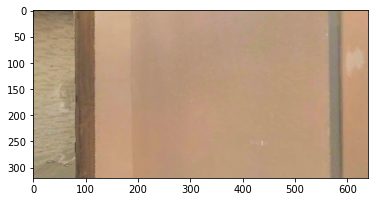

In [17]:
plt.imshow(observations['rgb'])

In [18]:
images = []
titles = []
semantic = prepare_semantic_observation(observations)
unique_values = np.unique(semantic)
for value in unique_values:
    obj = (semantic == value)

    scene = env.sim.semantic_annotations()
    instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}

    titles.append(value)

    images.append(Image.fromarray(obj))

In [19]:
{obj.category.index(): obj.category.name() for obj in scene.objects}

{1: 'wall',
 40: 'misc',
 16: 'stairs',
 4: 'door',
 2: 'floor',
 39: 'objects',
 17: 'ceiling',
 0: 'void',
 14: 'plant',
 24: 'column',
 -1: '',
 5: 'table',
 21: 'mirror',
 15: 'sink',
 7: 'cabinet',
 28: 'lighting',
 34: 'seating',
 20: 'towel',
 12: 'curtain',
 9: 'window',
 23: 'shower',
 38: 'clothes',
 11: 'bed',
 35: 'board_panel',
 37: 'appliances',
 31: 'shelving',
 26: 'counter',
 22: 'tv_monitor',
 3: 'chair'}

2
wall


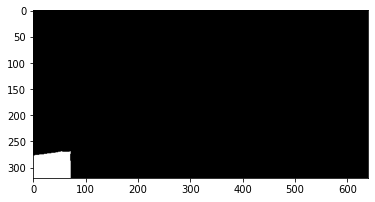

In [21]:
i = 1
plt.imshow(images[i])
print(titles[i])
print({obj.category.index(): obj.category.name() for obj in scene.objects}[i])

In [22]:
visualize.display_top_masks(observations['rgb'], np.array(images), titles, {obj.category.index(): obj.category.name() for obj in scene.objects})

IndexError: too many indices for array

In [14]:
dataset = HabitatDataset('/root/Obj_dataset')

In [15]:
!rm -r /root/Vetlin/dataset/Y/*/.ipynb_checkpoints

rm: cannot remove '/root/Vetlin/dataset/Y/*/.ipynb_checkpoints': No such file or directory


In [16]:
dataset.prepare_dataset()

/root/Vetlin/dataset/X 	 /root/Vetlin/dataset/Y
prepared 4058 images


In [17]:
(train_dataset, test_dataset) = dataset.split_on_train_and_val(3800, 250)

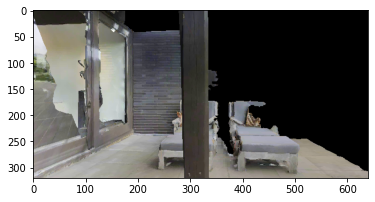

In [33]:
img = train_dataset.load_image(10)
plt.imshow(img)

wall


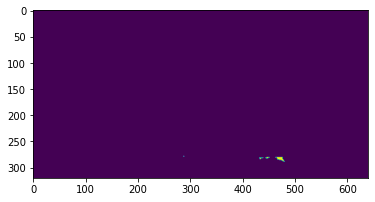

door


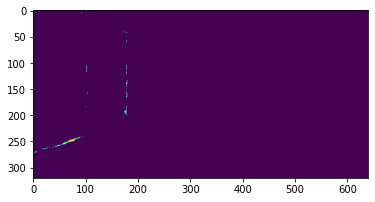

misc


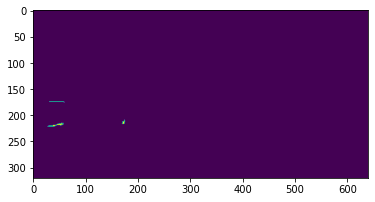

chair


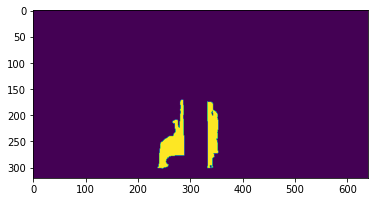

nope


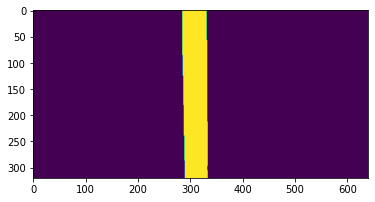

nope


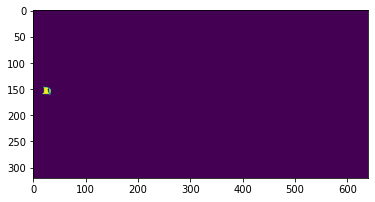

floor


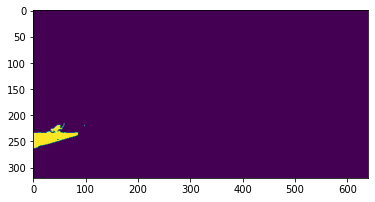

cabinet


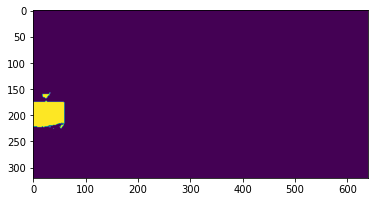

objects


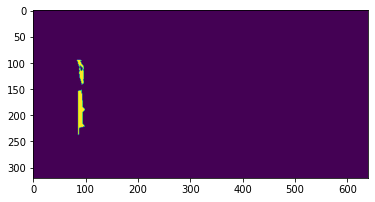

seating


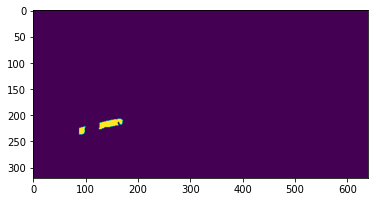

In [34]:
masks, class_ids = train_dataset.load_mask(10)

for i in range(masks.shape[2]):
    print(dataset.class_names[class_ids[i]])
    plt.imshow(masks[:, :, i])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['ceiling', 'window', 'cushion', 'bed', 'wall', 'floor', 'shelving', 'door', 'objects', 'tv_monitor', 'chest_of_drawers', 'chair', 'misc', 'seating', 'picture', 'board_panel', 'counter', 'shower', 'toilet', 'mirror', 'cabinet', 'void', 'lighting', 'sink', 'table', 'curtain', 'towel', 'bathtub', 'stool', 'stairs', 'clothes', 'nope', 'appliances', 'fireplace', 'beam', 'sofa', 'plant']
(320, 640, 15)
[ 4  9 22 14  7 12 24 11 31 31  0  5 20  8 13]


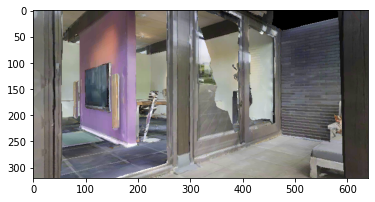

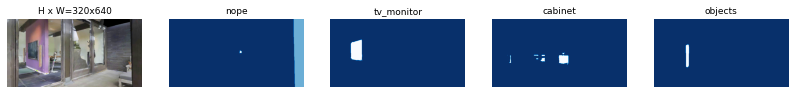

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(320, 640, 15)
[36  4 32 14 29  7 12 16 18 31 31  0  5 23 20]


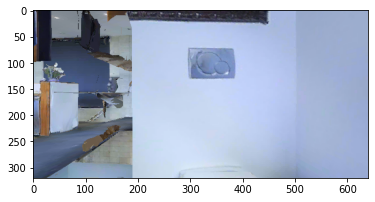

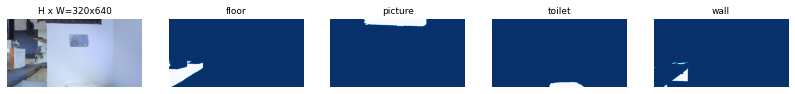

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(320, 640, 19)
[28  3  4 21 32  2 14 29  7 12 16 35 11 31 31  0  5 23  8]


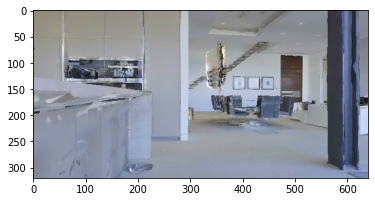

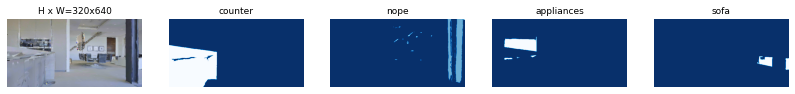

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(320, 640, 13)
[36  4  1  9 32 14  6  7 12 16 11  0  5]


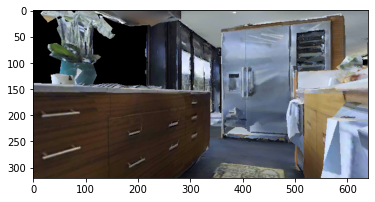

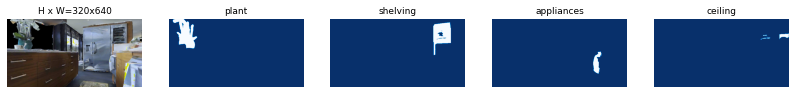

In [35]:
image_ids = np.random.choice(range(48), 4)
print(dataset.class_names)

for image_id in image_ids:

    img = dataset.load_image(image_id)
    (masks, class_ids) = dataset.load_mask(image_id)

    print(masks.shape)
    print(class_ids)

    plt.imshow(img)
    plt.show()

    visualize.display_top_masks(img, masks, class_ids, dataset.class_names)

In [21]:
import wandb
wandb_run = wandb.init(project="mask-r-cnn", reinit=True)#, config=config_cnn)

In [22]:
MODEL_DIR = "/root/Vetlin/logs"

model = modellib.MaskRCNN(mode="training", config=config_cnn,
                          model_dir=MODEL_DIR, wandb_log=wandb_run)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [24]:
COCO_MODEL_PATH = "/root/Vetlin/mask_rcnn_coco.h5"

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [27]:
import h5py

In [ ]:
model.train(train_dataset, test_dataset, 
            learning_rate=config_cnn.LEARNING_RATE, 
            epochs=2, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /root/Vetlin/logs/habitat20200708T1313/mask_rcnn_habitat_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

wandb: ERROR Can't save model, h5py returned error: can't pickle _thread.RLock objects


100/100 [==============================] - 9062s - loss: 4.7599 - rpn_class_loss: 0.4088 - rpn_bbox_loss: 2.2494 - mrcnn_class_loss: 0.7117 - mrcnn_bbox_loss: 0.7248 - mrcnn_mask_loss: 0.6651 - val_loss: 3.8469 - val_rpn_class_loss: 0.2377 - val_rpn_bbox_loss: 1.9257 - val_mrcnn_class_loss: 0.5687 - val_mrcnn_bbox_loss: 0.5342 - val_mrcnn_mask_loss: 0.5805
Epoch 2/2
 99/100 [============================>.] - ETA: 86s - loss: 4.1290 - rpn_class_loss: 0.2349 - rpn_bbox_loss: 2.1631 - mrcnn_class_loss: 0.6449 - mrcnn_bbox_loss: 0.5322 - mrcnn_mask_loss: 0.5539 

### 60/100 - ETA: 3401s - loss: 5.4405 - rpn_class_loss: 0.4878 - rpn_bbox_loss: 2.3755 - mrcnn_class_loss: 0.9415 - mrcnn_bbox_loss: 0.8576 - mrcnn_mask_loss: 0.7781
loss: 4.7599 - rpn_class_loss: 0.4088 - rpn_bbox_loss: 2.2494 - mrcnn_class_loss: 0.7117 - mrcnn_bbox_loss: 0.7248 - mrcnn_mask_loss: 0.6651 - val_loss: 3.8469 - val_rpn_class_loss: 0.2377 - val_rpn_bbox_loss: 1.9257 - val_mrcnn_class_loss: 0.5687 - val_mrcnn_bbox_loss: 0.5342 - val_mrcnn_mask_loss: 0.5805 

### loss: 4.1210 - rpn_class_loss: 0.2348 - rpn_bbox_loss: 2.1543 - mrcnn_class_loss: 0.6458 - mrcnn_bbox_loss: 0.5323 - mrcnn_mask_loss: 0.5538

In [36]:
model.keras_model.save_weights('/root/mask_r_cnn_trained_v1.h5')

In [34]:
model.load_weights('my_model_weights.h5', by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(train_dataset, test_dataset, 
            learning_rate=config_cnn.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")


Starting at epoch 2. LR=0.0001

Checkpoint Path: /root/mask-r-cnn/logs/habitat20200716T1959/mask_rcnn_habitat_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2

In [37]:
class InferenceConfig(InferenceConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /root/mask-r-cnn/logs/habitat20200716T1959/mask_rcnn_habitat_0004.h5
Re-starting from epoch 4


In [50]:
gt_bbox.shape

(18, 4)

In [51]:
gt_mask.shape

(640, 640, 18)

In [44]:
gt_class_id

array([36,  3,  4,  1, 32, 25, 14, 29,  7, 12, 18, 24, 11, 31, 27,  0,  5,
        8])

In [45]:
test_dataset.class_names

['ceiling',
 'window',
 'cushion',
 'bed',
 'wall',
 'floor',
 'shelving',
 'door',
 'objects',
 'tv_monitor',
 'chest_of_drawers',
 'chair',
 'misc',
 'seating',
 'picture',
 'board_panel',
 'counter',
 'shower',
 'toilet',
 'mirror',
 'cabinet',
 'void',
 'lighting',
 'sink',
 'table',
 'curtain',
 'towel',
 'bathtub',
 'stool',
 'stairs',
 'clothes',
 'nope',
 'appliances',
 'fireplace',
 'beam',
 'sofa',
 'plant']

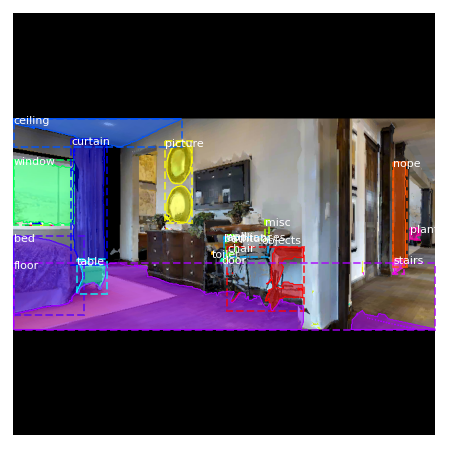

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


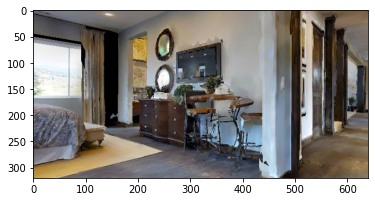

In [42]:
# Test on a random image
image_id = 5

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_dataset, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_dataset.class_names, figsize=(8, 8))

img = test_dataset.load_image(image_id)

plt.imshow(img)
plt.show()